In [120]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import math
from sklearn import metrics as m

warnings.filterwarnings("ignore")

Read the data & Prepare the data
===========

In [121]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

In [122]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)


data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  
print(data.shape)


(466680, 405)
(465879, 405)


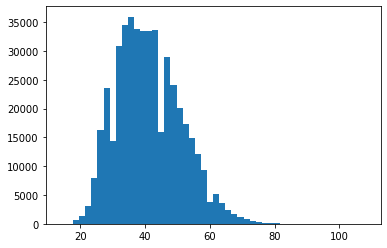

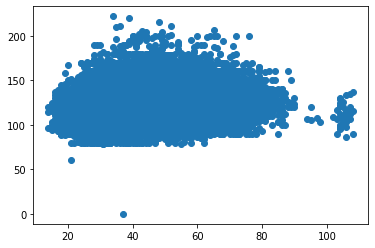

In [123]:

# data=data[data.AGE>30]
# data=data[data.AGE <= 40 ]
# data=data[data.SEX==1]

plt.hist(data.AGE,bins=50)
plt.show()
plt.scatter(data.AGE,data.S000501)
plt.show()

In [124]:


# change field 38 to 3 group
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

data = data[
    [
        "L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000",
        "S000501",
    ]
]
data = data.dropna().reset_index()

# data=data[data.FIELD_15==0]
# data=data[data.FIELD_22==0]
# data=data[data.SEX==0]
# data=data[data.AGE < 40]

# data = data.sample(100000, random_seed=42)

print(data.shape)

(403309, 17)


In [125]:
print(data.shape)
print(data.columns)
data.head()

(403309, 17)
Index(['index', 'L190300', 'FIELD_29', 'S000300', 'FIELD_38', 'AGE', 'SEX',
       'L100700', 'L100800', 'FIELD_33', 'FIELD_41', 'FIELD_42', 'L190500',
       'L101600', 'L103100', 'L103000', 'S000501'],
      dtype='object')


,index,L190300,FIELD_29,S000300,FIELD_38,AGE,SEX,L100700,L100800,FIELD_33,FIELD_41,FIELD_42,L190500,L101600,L103100,L103000,S000501
0,0,3.76,0.0,22.6,2.0,46.0,0.0,2.6,111.0,2.0,7.0,7.0,35.4,48.0,73.0,70.0,130.0
1,1,4.02,0.0,22.9,2.0,47.0,0.0,3.7,103.0,2.0,4.0,5.0,38.2,49.0,79.0,50.0,132.0
2,2,4.24,0.0,24.3,3.0,48.0,0.0,2.6,113.0,2.0,3.0,3.0,40.7,42.0,65.0,75.0,132.0
3,3,4.28,0.0,24.3,2.0,49.0,0.0,2.0,105.0,2.0,0.0,0.0,41.1,53.0,62.0,130.0,140.0
4,4,4.34,0.0,23.7,3.0,50.0,0.0,2.8,118.0,2.0,2.0,2.0,40.4,49.0,61.0,92.0,145.0


In [126]:
# test = pd.read_csv("test.txt")
# testpd = data[data.index.isin(list(test[["Unnamed: 0"]].values.astype(int).ravel()))]

# train = pd.read_csv("train.txt")
# trainpd = data[
#     data.index.isin(list(train[["Unnamed: 0"]].values.astype(int).ravel()))
# ]

# # list(xtest[["Unnamed: 0"]].values.astype(int).ravel())


In [127]:
x = data[
    [
        "L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000",
    ]
]

y = data[["S000501"]]

In [128]:
from keras.layers import Layer
from keras import backend as K


class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(int(input_shape[1]), self.units),
            initializer="uniform",
            trainable=True,
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Apply PCA
===========

In [129]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x)
# print(x.shape)

feature scaling
=======

In [130]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [131]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# K = range(1, 20)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(
#         sum(np.min(cdist(x, kmeanModel.cluster_centers_, "euclidean"), axis=1))
#         / x.shape[0]
#     )
#     print(k)

# # Plot the elbow
# plt.plot(K, distortions, "bx-")
# plt.xlabel("k")
# plt.ylabel("Distortion")
# plt.title("The Elbow Method showing the optimal k")
# plt.show()

In [132]:
# kmeanModel = KMeans(n_clusters=10).fit(x)
# x["lbl"] = kmeanModel.labels_

Random Forest Regressor
=============

In [133]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures


# # Step 2b: Transform input data
# x = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

# ylable = y[["S000501"]]
# xtrain, xtest, ytrain, ytest = train_test_split(
#     x, ylable, random_state=42, test_size=0.3
# )

# # Step 3: Create a model and fit it
# model = LinearRegression().fit(xtrain, ytrain)

# # Step 4: Get results
# r_sq = model.score(xtest, ytest)
# intercept, coefficients = model.intercept_, model.coef_

# # Step 5: Predict
# ypred = model.predict(xtest)
# print("r2_score", m.r2_score(ytest, ypred))

In [134]:
ylable = y[["S000501"]]
xtrain, xtest, ytrain, ytest = train_test_split(
    x, ylable, random_state=42, test_size=0.3
)

In [135]:
# xtrain= trainpd[["L190300",
#         "FIELD_29",
#         "S000300",
#         "FIELD_38",
#         "AGE",
#         "SEX",
#         "L100700",
#         "L100800",
#         "FIELD_33",
#         "FIELD_41",
#         "FIELD_42",
#         "L190500",
#         "L101600",
#         "L103100",
#         "L103000"]]
# ytrain=trainpd[["S000501"]] 

# xtest=testpd[["L190300",
#         "FIELD_29",
#         "S000300",
#         "FIELD_38",
#         "AGE",
#         "SEX",
#         "L100700",
#         "L100800",
#         "FIELD_33",
#         "FIELD_41",
#         "FIELD_42",
#         "L190500",
#         "L101600",
#         "L103100",
#         "L103000"]]
# ytest= testpd[["S000501"]] 

In [136]:
# xtest.shape

In [137]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0, verbose=0, n_estimators=100)
regr.fit(xtrain, ytrain)
print(regr.feature_importances_)
ypred = regr.predict(xtest)

[2.19951319e-02 1.13660632e-03 6.29136716e-01 4.63112052e-03
 8.51325338e-02 1.70395430e-01 8.34341594e-04 5.12255124e-02
 1.01316912e-03 6.83584723e-05 6.66843228e-05 2.61936465e-02
 1.21737383e-03 1.52486116e-03 5.42851436e-03]


mean_squared_error 114.95271835305253
root mean_squared_error 10.721600549966993
mean_absolute_error 8.553860963859647
r2_score 0.29845226482665377


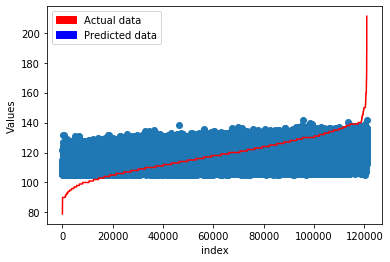

,t + 1,pred (t +1)
59723,190.0,124.276286
81984,190.0,132.487987
25314,190.0,133.452917
77423,190.0,125.608256
47093,191.0,116.026748
81708,194.0,125.637069
47481,200.0,112.422741
61562,205.0,128.623565
56022,207.0,116.881133
53311,211.0,122.933717


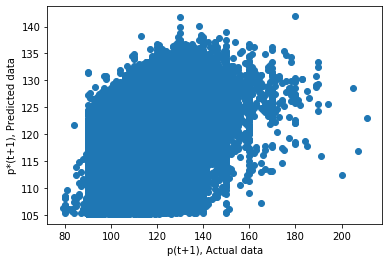

In [138]:
print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(30)

import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.tail(10)

In [139]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

< 5  35.354937888968784
< 10  64.54009736100436
< 15  84.43959567908887
< 20  94.57406626829652
< 25  98.16435661567198
< 30  99.38756787582753


In [140]:
# xtest.to_csv("xtest.txt", sep=",")
# ytest.to_csv("ytest.txt", sep=",")

# xtrain.to_csv("xtrain.txt", sep=",")
# ytrain.to_csv("ytrain.txt", sep=",")

# pd.DataFrame(ypred,ytest.index.ravel()).to_csv("ypred_s000501.txt", sep=",")

In [141]:
ytest.shape

(120993, 1)

xg boost
==========

In [142]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective="reg:squarederror")
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [143]:
ypred = xg_reg.predict(xtest)

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(10)

mean_squared_error 112.1825842969909
root mean_squared_error 10.59162802863615
mean_absolute_error 8.445194767343809
r2_score 0.3153581831990051


,t + 1,pred (t +1)
0,110.0,120.052856
1,118.0,114.848770
2,131.0,119.520370
3,115.0,116.265152
4,130.0,120.273720
5,125.0,122.717873
6,116.0,116.911064
7,117.0,123.353439
8,133.0,119.192833
9,91.0,110.387611


In [144]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

< 5  35.81446860562181
< 10  65.2079045895217
< 15  85.00657062805286
< 20  94.84515633135801
< 25  98.28833072987693
< 30  99.43054556875191


In [145]:
# xtest.to_csv("xtest.txt", sep=",")
# ytest.to_csv("ytest.txt", sep=",")

# xtrain.to_csv("xtrain.txt", sep=",")
# ytrain.to_csv("ytrain.txt", sep=",")

# pd.DataFrame(ypred).to_csv("ypred_s000501.txt", sep=",")

ANN
==========

In [ ]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
model = Sequential()
model.add(
    Dense(input_dim=16, units=512, activation="relu", kernel_initializer="uniform")
)
model.add(Dense(units=512, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(512, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# model.add(Dense(units=256, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(256, 0.5))
# model.add(Dense(units=256, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(256, 0.5))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(units=128, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(128, 0.5))
model.add(Dense(units=128, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(128, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# model.add(Dense(units=64, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(64, 0.5))
# model.add(Dense(units=64, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(64, 0.5))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(units=32, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(32, 0.5))
model.add(Dense(units=32, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(32, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=16, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(16, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=8, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(8, 0.5))

model.add(Dense(units=1, kernel_initializer="uniform"))
model.compile(
    loss="mean_squared_error", optimizer="Nadam", metrics=["mean_squared_error"]
)

In [ ]:
h = model.fit(xtrain, ytrain, validation_split=0.2, epochs=100, batch_size=10000)

In [ ]:
ypred = model.predict(xtest)

import math

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(10)

In [ ]:
history = h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["val_mean_squared_error"])
plt.plot(history.history["mean_squared_error"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print(np.mean(ypredPD["diff"]))
print(np.std(ypredPD["diff"]))
print(100 * ypredPD[ypredPD["diff"] <= 5].shape[0] / ypredPD.shape[0])

In [ ]:
import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.head(10)

In [ ]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
from keras.layers import Layer
from keras import backend as K


class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(int(input_shape[1]), self.units),
            initializer="uniform",
            trainable=True,
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)